# PA005: High Value Customer Identification (Insiders)

# 0.0. Imports

In [1]:
from matplotlib          import pyplot        as plt
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.manifold    import TSNE
from sqlalchemy          import create_engine
import sqlite3

import pandas as pd
import numpy as np
import umap.umap_ as umap
import seaborn as sns


import re
import warnings



/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Helper Functions

In [2]:
warnings.simplefilter("ignore")

def num_attributes(df1):
    
    num_attributes = df1.select_dtypes(['int64', 'float64'])

    #central tendency
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #dispersion
    d1 = pd.DataFrame(num_attributes.apply(np.min)).T
    d2 = pd.DataFrame(num_attributes.apply(np.max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
    return m

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set(font_scale = 2)
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3. Load Data

In [3]:
df_raw = pd.read_csv(r'./data/Ecommerce.csv')


# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

## 1.2. Data Shape

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NAs


In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill NAs

In [10]:
#remove na
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[-df1['customer_id'].isna()]



In [11]:
len(df_missing)

135080

In [12]:
len(df_not_missing)

406829

In [13]:
#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

#merge
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns
df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)




In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [16]:
#invoice_no 
# df1['invoice_no'] = df1['invoice_no'].astype(int)


#stock_code 
# df1['stock_code'] = df1['stock_code'].astype(int)


#invoice_date  --> Month --> b
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format=('%d-%b-%y'))


#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive statistics

In [17]:

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [18]:
m1 = num_attributes(df1)
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611121,2.08,96.759763,186.506973,59005.719804
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Investigating

1. Negative quantity (devolution?)
2. Price = 0 (Promo?)

## 1.7.2. Categorical Attributes

In [19]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [20]:
df1['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

#### Invoice no

In [21]:

#invoice_no -- some of them has one char
df_invoice_char = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]   

len(df_invoice_char[df_invoice_char['quantity']<0])


print('Total of invoices with letter: {}'.format(len(df_invoice_char)))
print('Total of negative quantaty: {}'.format(len(df1[df1['quantity']<0])))
print('Letter means negative quantity')

Total of invoices with letter: 9291
Total of negative quantaty: 10624
Letter means negative quantity


#### Stock Code

In [22]:
#all stock codes with char
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

#remove stock code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
# df1 = df1[-df1.isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [23]:
df1.head(2) #remove description


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850


#### Country


In [24]:
df1['country'].value_counts(normalize='True').head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [25]:
df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Data Filtering

In [26]:
df2 = df1.copy()

In [27]:
df2[df2['customer_id'].isin( [16446] )]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


In [28]:
 # === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df_returns = df2.loc[df1['quantity'] < 0, :]
df_purchase = df2.loc[df1['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [29]:
df3 = df2.copy()

## 3.1. Feature Creation

In [30]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )



### 3.1.1. Gross Revenue

In [31]:
#calculate gross revenue
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price'] 

#gross revenue by customer
df_monetary = df_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how= 'left')
df_ref.isna().sum()

len(df_ref)

5786

### 3.1.2. Recency - Days from last purchase


In [32]:
#recency 

df_recency = df_purchase.loc[:,['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency  = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
len(df_ref)

5786

### 3.1.4. Quantity of purchase

In [33]:

# Número de compras
df_invoice = df_purchase.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qt_invoice'})
df_ref = pd.merge(df_ref, df_invoice, on='customer_id', how='left')
len(df_ref)

5786

### 3.1.4. Quantity of products purchase

In [34]:
# Número de compras
df_stock_code = df_purchase.loc[:,['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qt_products'})
df_ref = pd.merge(df_ref, df_stock_code, on='customer_id', how='left')
len(df_ref)


5786

### 3.1.6. Frequency

In [35]:
df_aux = (df_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
                                                            max_ = ('invoice_date', 'max'),
                                                            min_ = ('invoice_date', 'min'),
                                                            days = ('invoice_date', lambda x: (x.max() - x.min()).days ),
                                                            buys = ('invoice_no', 'count'))).reset_index()

# #calculate frequency
df_aux['frequency'] = df_aux[['buys', 'days']].apply(lambda x: x['buys']/x['days'] if x['days']!= 0 else 0, axis=1)


#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
qt_invoice       91
qt_products      91
frequency        91
dtype: int64

### 3.1.7. Returns


In [36]:
df_aux = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qt_returns'})
df_aux['qt_returns'] = -1*df_aux['qt_returns']
df_aux['qt_returns'] = df_aux['qt_returns'].fillna(0)
#merge
df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')



In [37]:
df_ref.loc[df_ref['qt_returns'].isna(), 'qt_returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qt_invoice       91
qt_products      91
frequency        91
qt_returns        0
dtype: int64

# 4.0. Machine Learning Model

In [86]:

df4 = df_ref.dropna()
df43 = df4.copy()
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']  = mm.fit_transform( df43[['recency_days']] )
df43['qt_products'] = mm.fit_transform( df43[['qt_products']])
df43['frequency']     = mm.fit_transform( df43[['frequency']])
df43['qt_returns']  = mm.fit_transform( df43[['qt_returns']])

X = df43[cols_selected].drop('customer_id', axis=1).copy()

## 4.1. KMeans

In [60]:
# model definition
k = 8


#model definition
kmeans_model = c.KMeans(n_clusters=k, random_state=42)

#model training
kmeans_model.fit(X)

#model predict
labels = kmeans_model.predict(X)

#model performance
sil = m.silhouette_score(X, labels, metric='euclidean')




In [61]:
sil

0.5377337303161348

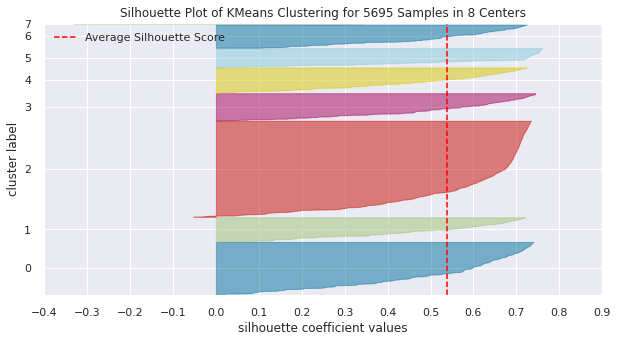

In [62]:
plt.figure(figsize=(10,5))
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

# 5.0. Exploratory Data Analisys

In [63]:
df5 = df_ref.dropna()


## 5.1. Estudo do Espaço

In [79]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qt_products', 'frequency', 'qt_returns']
df43 = df43[ cols_selected ].copy() 

### 5.1.1. PCA

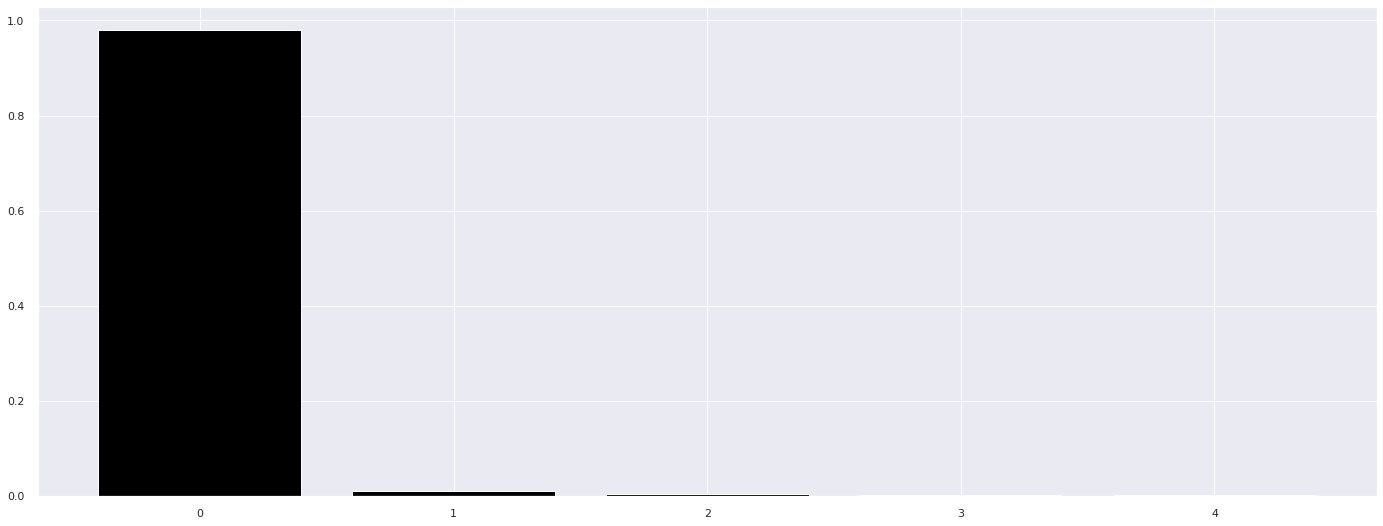

In [65]:



pca = dd.PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

#plot explained variable
features = range(pca.n_components)
plt.bar(features, pca.explained_variance_ratio_, color='black');

#pca component
df_pca = pd.DataFrame(principal_components)


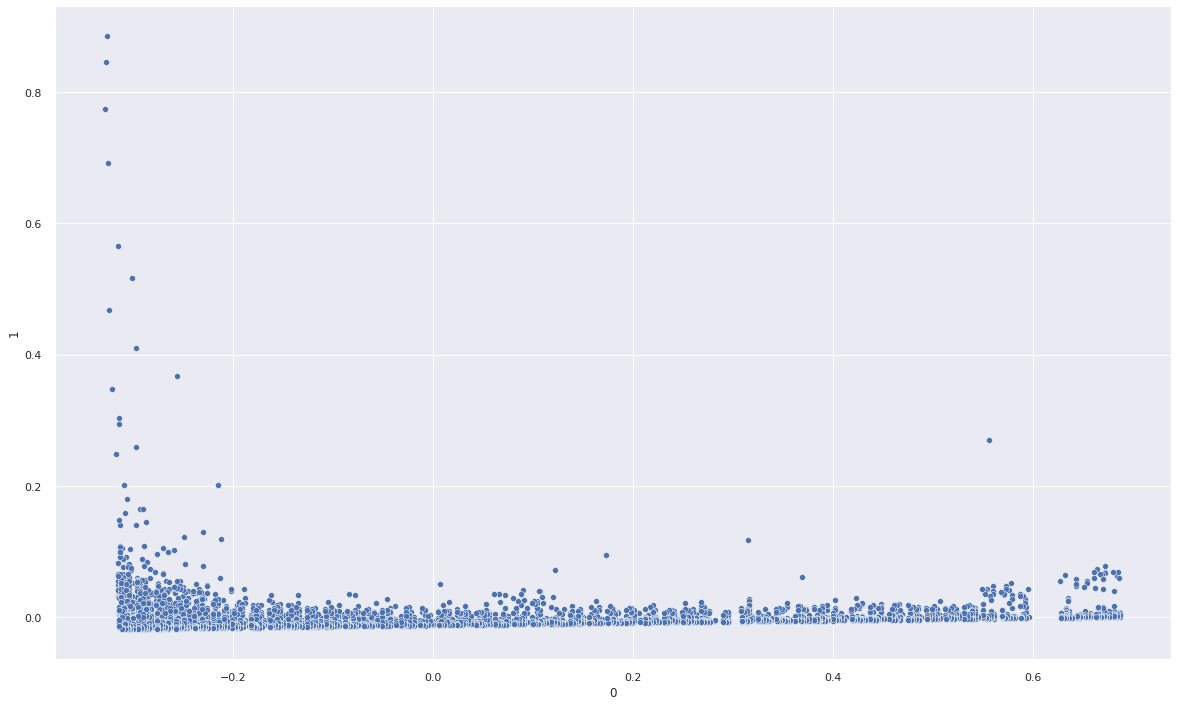

In [66]:
plt.figure(figsize=(20,12));
sns.scatterplot(x=0, y=1, data=df_pca);

### 5.1.2. UMAP

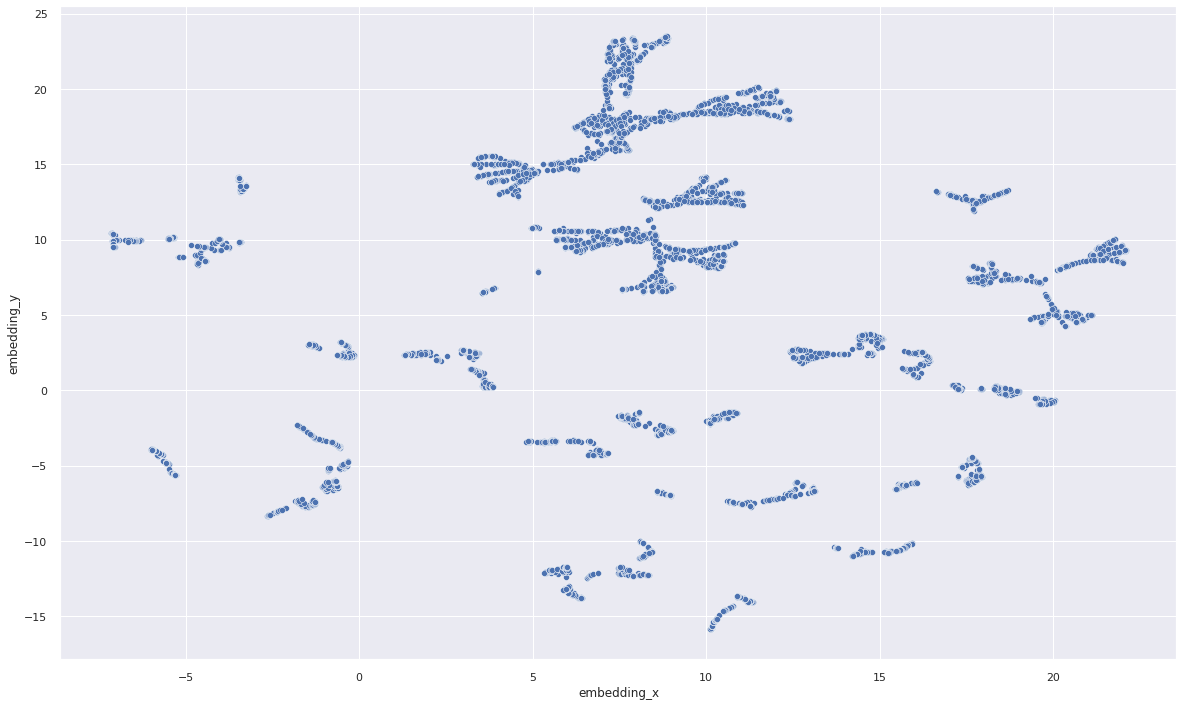

In [67]:

reducer = umap.UMAP( random_state=3)
embedding = reducer.fit_transform(X)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

plt.figure(figsize=(20,12));
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_pca);

### 5.1.3. T-SNE

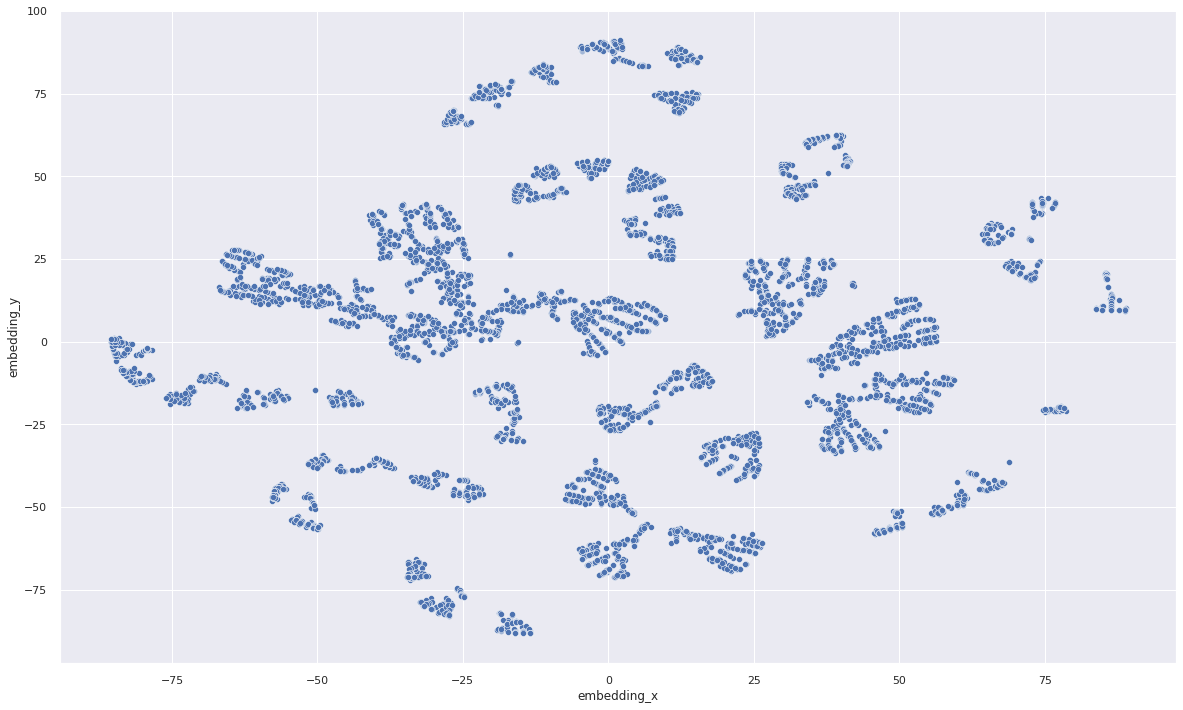

In [68]:
reducer = TSNE( n_components=2,n_jobs=-1, random_state=3)
embedding = reducer.fit_transform(X)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

plt.figure(figsize=(20,12));
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_pca);

# 6.0. Cluster Analisys

In [87]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qt_products', 'frequency', 'qt_returns']
df9 = df4.copy()
df9['cluster'] = labels


In [88]:
df9.head()

,customer_id,gross_revenue,recency_days,qt_invoice,qt_products,frequency,qt_returns,cluster
0,17850,5391.21,372.0,34.0,297.0,34.000000,40.0,5
1,13047,3232.59,56.0,9.0,171.0,0.028391,35.0,0
2,12583,6705.38,2.0,15.0,232.0,0.040431,50.0,2
3,13748,948.25,95.0,5.0,28.0,0.017986,0.0,4
4,15100,876.00,333.0,3.0,3.0,0.075000,22.0,5


## 6.1. Cluster Profile

In [89]:

df92 = df9[cols_selected].copy()


df92['cluster']= labels

 # Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index().rename(columns={'gross_revenue': 'avg_gmv'})
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )


# Sum Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).sum().reset_index().rename(columns={'gross_revenue': 'total_gmv'})
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg products
df_qtde_products = df92[['qt_products', 'cluster']].groupby( 'cluster' ).mean().reset_index().rename(columns={'qt_products': 'avg_products'})
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# total products
df_qtde_products = df92[['qt_products', 'cluster']].groupby( 'cluster' ).sum().reset_index().rename(columns={'qt_products': 'total_products'})
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns avg
df_qtde_returns = df92[['qt_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index().rename(columns={'gross_revenue': 'avg_returns'})
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'avg_gmv', ascending=False )


,cluster,customer_id,perc_customer,avg_gmv,total_gmv,recency_days,avg_products,total_products,frequency,qt_returns
7,7,12,0.210711,121078.380833,1452940.57,4.333333,2773.916667,33287.0,0.241589,824.000000
2,2,2043,35.873573,2674.933000,5464888.12,16.053353,138.710720,283386.0,0.037982,32.131669
0,0,1115,19.578578,1091.372691,1216880.55,61.211659,65.326457,72839.0,0.018796,8.379372
5,5,401,7.041264,1086.688304,435762.01,352.501247,74.957606,30058.0,0.093306,187.448878
4,4,539,9.464442,937.796030,505472.06,115.391466,60.517625,32619.0,0.015304,4.294991
6,6,492,8.639157,711.013984,349818.88,229.662602,43.579268,21441.0,0.014024,22.392276
3,3,577,10.131694,695.872149,401518.23,172.798960,53.883882,31091.0,0.022967,3.665511
1,1,516,9.060579,537.556066,277378.93,287.897287,43.974806,22691.0,0.008170,5.005814


In [90]:
#Cluster 7 : Insider
#Cluster 2 : More frequency
#Cluster 0 : Lazy
#Cluster 5 : Hibernating (High recency)
#Cluster 4 : More products
#Cluster 6 : Forgotten
#Cluster 3 : Lost
#Cluster 1 : One-time customer

## 6.2. Hipóteses do Negócio

#### H1: Insiders cluster customers have a volume (products) of purchases above 10% of total purchases

**False** The insider cluster has a product purchase volume of 6% of the total.

In [94]:
df10 = df9.copy()
df_aux = df10[['qt_products', 'cluster']].groupby('cluster').sum().reset_index()

#total products
total = df_aux['qt_products'].sum()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==7, 'qt_products']
print('% Sales Insiders (Products): {:.2f}%'.format(100*(df_aux_insider.sum())/total))


% Sales Insiders (Products): 6.31%


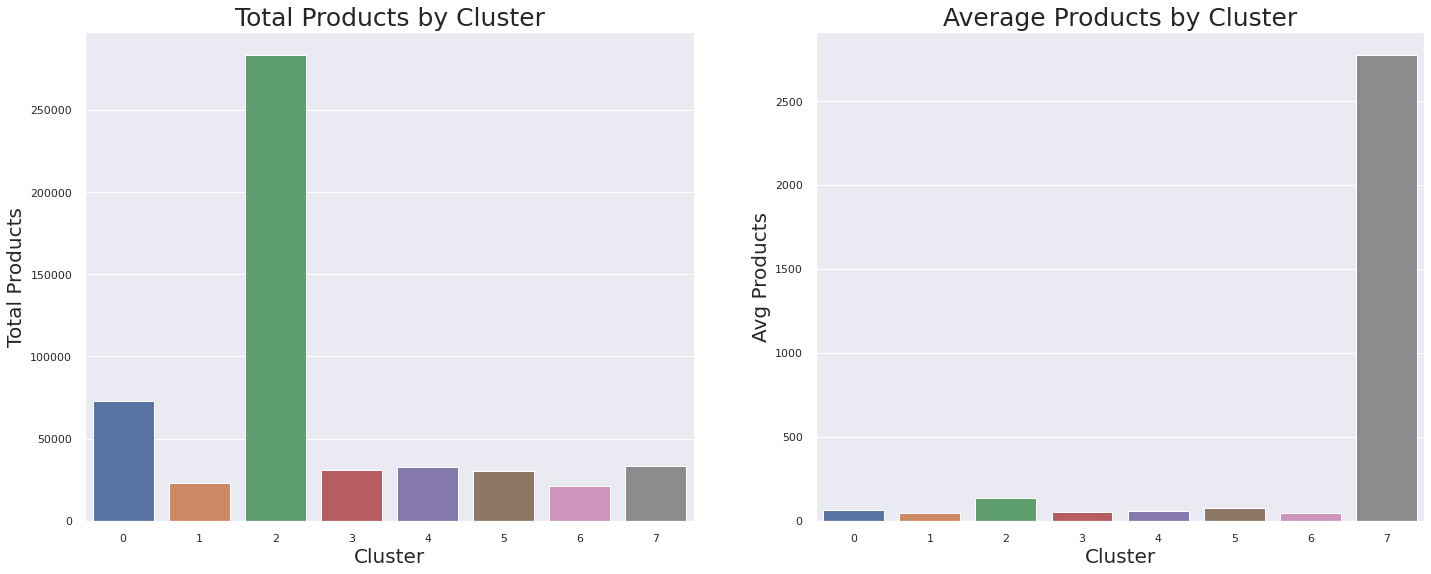

In [95]:
# sns.set(font_scale = 1)

df_aux = df10[['qt_products', 'cluster']].groupby('cluster').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='cluster', y='qt_products', data = df_aux);
plt.title('Total Products by Cluster', fontsize=25);
plt.xlabel("Cluster",fontsize=20);
plt.ylabel("Total Products",fontsize=20);


df_aux = df10[['qt_products', 'cluster']].groupby('cluster').mean().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='cluster', y='qt_products', data = df_aux);
plt.title('Average Products by Cluster', fontsize=25);
plt.xlabel("Cluster",fontsize=20);
plt.ylabel("Avg Products",fontsize=20);




#### H2: Insiders cluster customers have a volume (revenue) of purchases above 10% of total purchases

**True** The insider cluster has a GMV volume of 14% of the total.

In [96]:
df_aux = df10[['gross_revenue', 'cluster']].groupby('cluster').sum().reset_index()

#total products
total = df10['gross_revenue'].sum()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==7, 'gross_revenue']

print('% GMV Insiders: {:.2f}%'.format((df_aux_insider.sum())/total*100))

% GMV Insiders: 14.38%


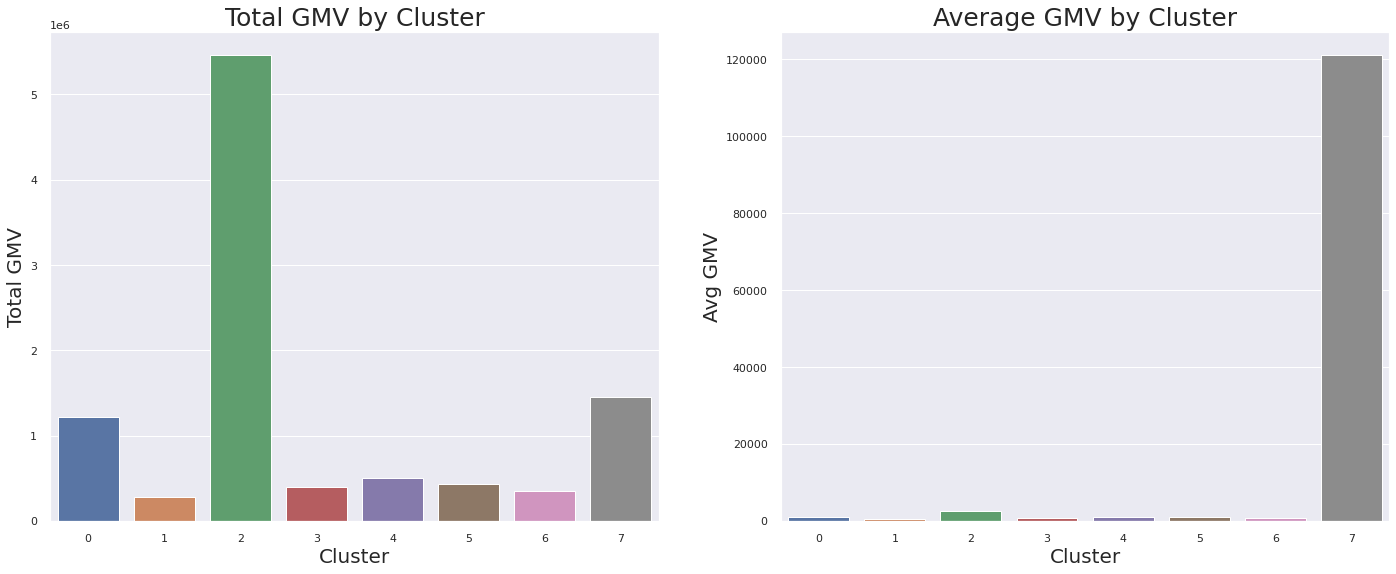

In [97]:


df_aux = df10[['gross_revenue','cluster']].groupby('cluster').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='cluster', y='gross_revenue', data = df_aux);
plt.title('Total GMV by Cluster', fontsize=25);
plt.xlabel("Cluster",fontsize=20);
plt.ylabel("Total GMV",fontsize=20);


df_aux = df10[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
plt.subplot(1,2,2)

sns.barplot(x='cluster', y='gross_revenue', data = df_aux);
plt.title('Average GMV by Cluster', fontsize=25);
plt.xlabel("Cluster",fontsize=20);
plt.ylabel("Avg GMV",fontsize=20);




#### H3: Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes
**Falso** O número de devoluções dos insiders é 6x maior que a médiatotal

In [98]:
df_aux= df10[['cluster','qt_returns']].groupby('cluster').mean().reset_index()

insider = df_aux.loc[df_aux['cluster']==7, 'qt_returns'].mean()

total = df_aux['qt_returns'].mean()

print('% média de retornos de insiders em relação ao total {:.0f}%'.format((insider)/total*100))


% média de retornos de insiders em relação ao total 606%


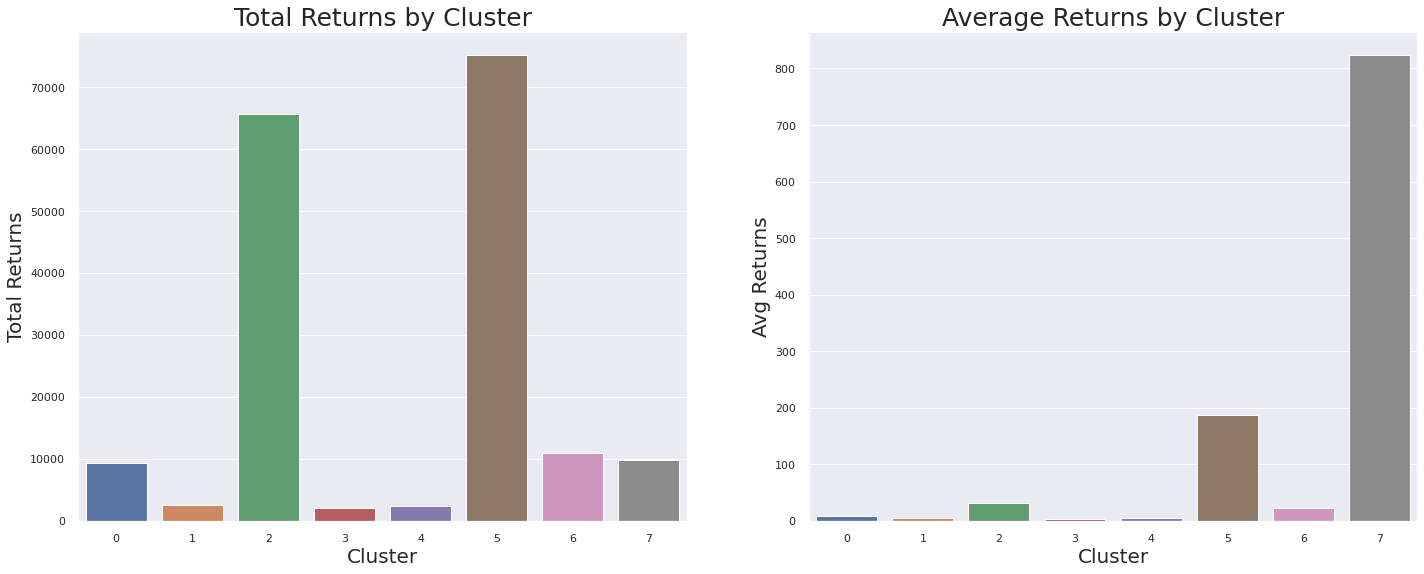

In [99]:


df_aux = df10[['qt_returns','cluster']].groupby('cluster').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='cluster', y='qt_returns', data = df_aux);
plt.title('Total Returns by Cluster', fontsize=25);
plt.xlabel("Cluster",fontsize=20);
plt.ylabel("Total Returns",fontsize=20);


df_aux = df10[['qt_returns', 'cluster']].groupby('cluster').mean().reset_index()
plt.subplot(1,2,2)

sns.barplot(x='cluster', y='qt_returns', data = df_aux);
plt.title('Average Returns by Cluster', fontsize=25);
plt.xlabel("Cluster",fontsize=20);
plt.ylabel("Avg Returns",fontsize=20);




#### H4: A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.

**Verdadeira** A mediana do GMV é 16896% maior nos Insiders do que a mediana do total 

In [100]:
df_aux = df10[['gross_revenue', 'cluster']].groupby('cluster').median().reset_index()

#total products
total = df10['gross_revenue'].median()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==7, 'gross_revenue']
median = df_aux_insider.median()

print('Mediana GMV total: {:.2f}'.format(total))

print('Mediana GMV Insiders: {:.2f}'.format(df_aux_insider.median()))

print('Diferença: {:.0f}% maior nos Insiders'.format((median-total)/total*100))

Mediana GMV total: 613.20
Mediana GMV Insiders: 104221.01
Diferença: 16896% maior nos Insiders


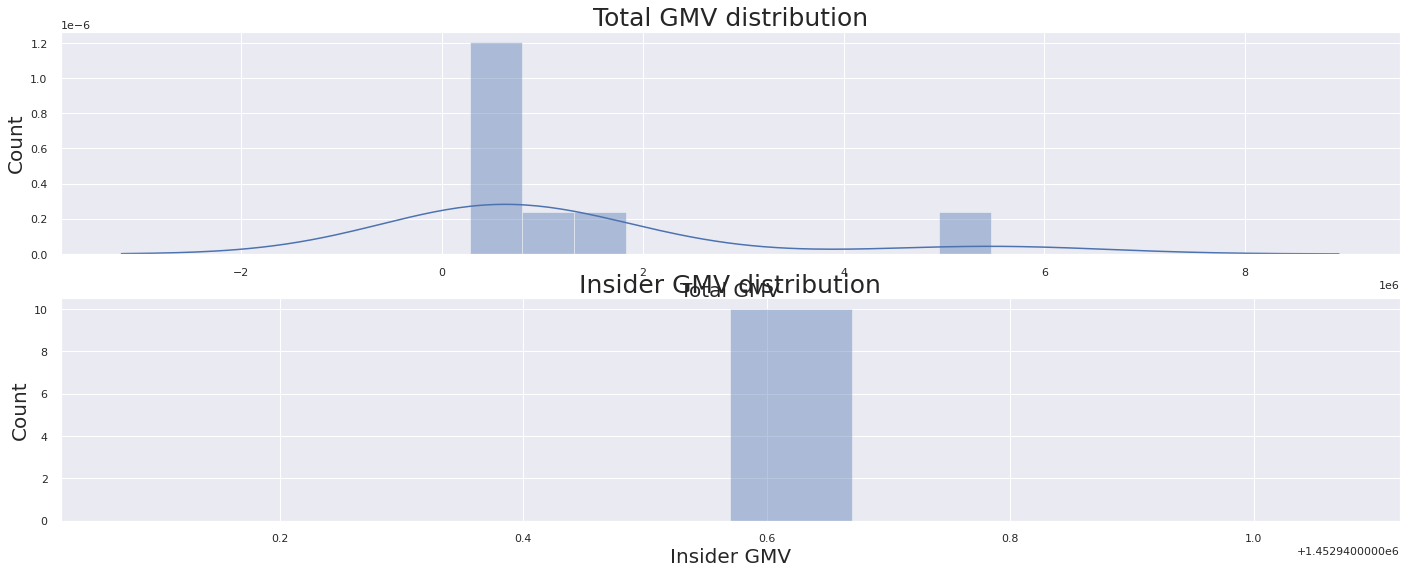

In [101]:


df_aux = df10[['gross_revenue','cluster']].groupby('cluster').sum().reset_index()
plt.subplot(2,1,1)
sns.distplot(df_aux['gross_revenue'], bins=10);
plt.title('Total GMV distribution', fontsize=25);
plt.xlabel("Total GMV",fontsize=20);
plt.ylabel("Count",fontsize=20);


df_aux = df_aux[df_aux['cluster']==7]
plt.subplot(2,1,2)
sns.distplot(df_aux['gross_revenue'],bins=10);
plt.title('Insider GMV distribution', fontsize=25);
plt.xlabel("Insider GMV",fontsize=20);
plt.ylabel("Count",fontsize=20);



In [102]:
sns.distplot

<function seaborn.distributions.distplot(a=None, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None, x=None)>

#### H5. **A GMV dos clientes insiders esta concentrados no 3 quartil**

**Falso**. O faturamento do cluster insiders está concentrada no quartil 2


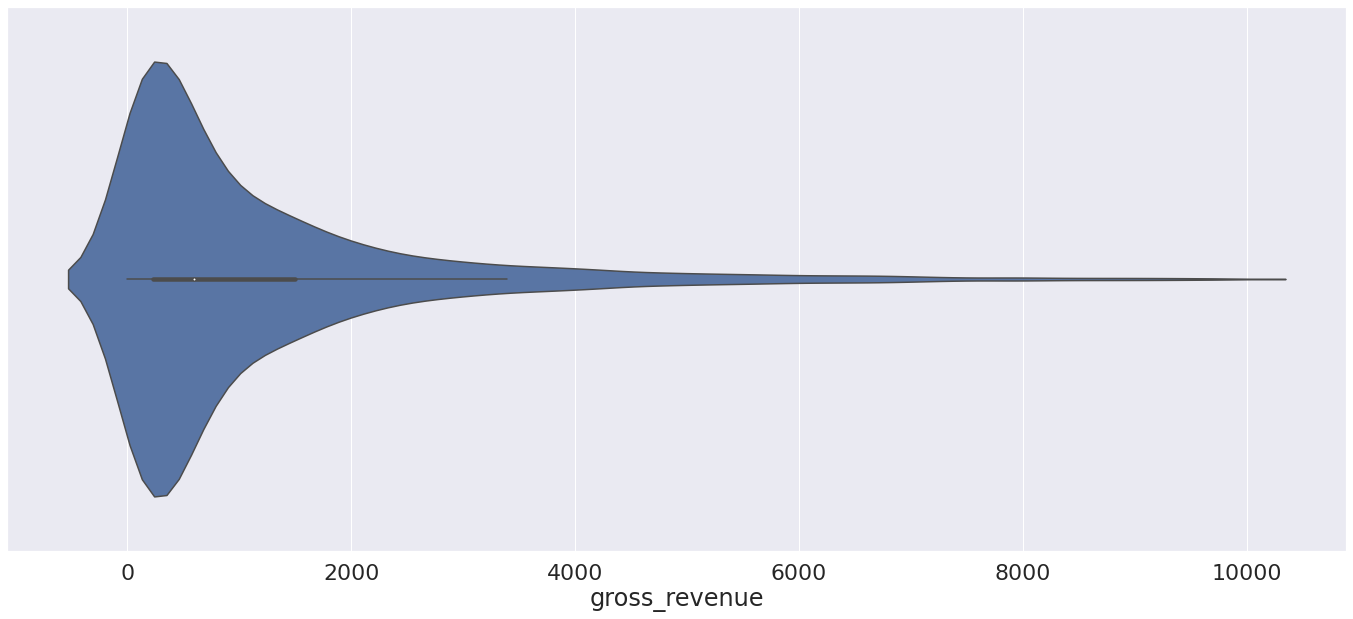

In [103]:
sns.set(font_scale = 2)
plt.figure(figsize=(24,10))
sns.violinplot(x=df10.loc[df10['gross_revenue']<10000,'gross_revenue']);


In [104]:
df_merge = pd.merge(df2, df10[['cluster','customer_id']], on='customer_id', how='left')
df_merge = df_merge.dropna().drop_duplicates('customer_id')

In [105]:
df_merge['gross_revenue'] = df_merge['unit_price']*df_merge['quantity']

returned = df_merge.loc[(df_merge['cluster']==5)&(df_merge['quantity']<0), 'gross_revenue'].sum()

purchase = df_merge.loc[(df_merge['cluster']==5)&(df_merge['quantity']>=0), 'gross_revenue'].sum()


print('Faturamento retornado em devolução: {:.1f}%'.format(abs(100*returned/(purchase-returned))))

Faturamento retornado em devolução: 0.1%


4048.85
252685.98000000004


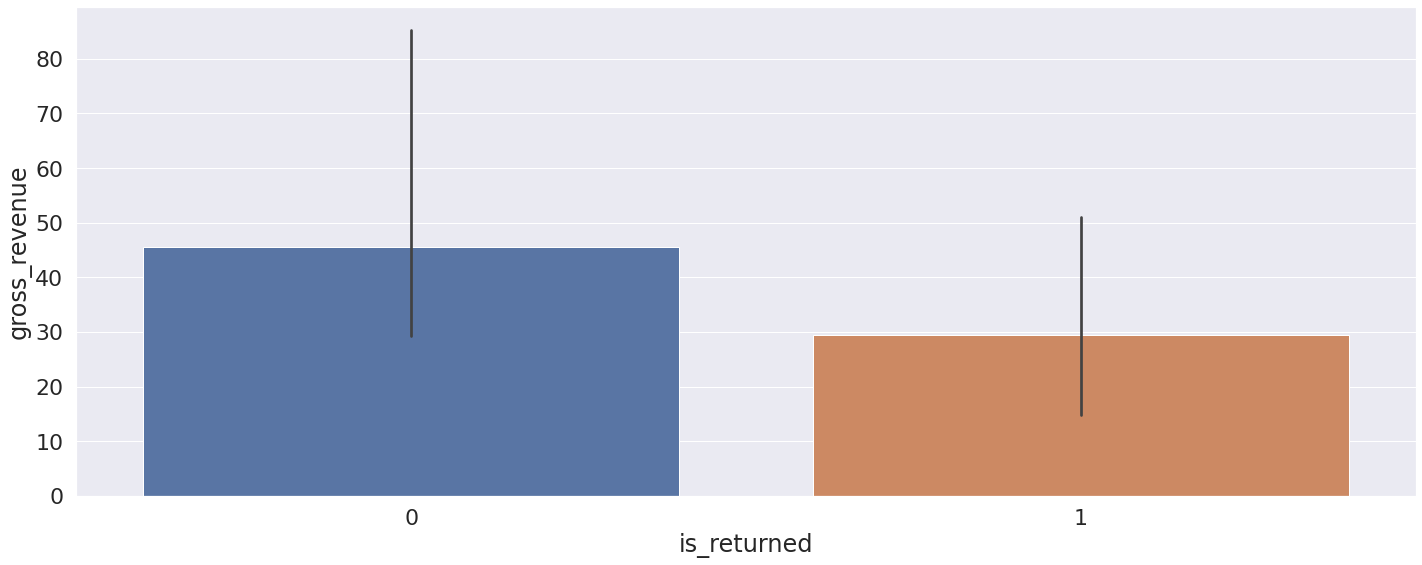

In [106]:
df_aux = df_merge[['customer_id', 'quantity', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_aux['is_returned'] = df_aux['quantity'].apply(lambda x: 1 if x<0 else 0)
df_aux['gross_revenue'] = abs(df_aux['gross_revenue'])
sns.barplot(x='is_returned', y='gross_revenue', data=df_aux);

print(df_aux.loc[df_aux['is_returned']==1, 'gross_revenue'].sum())
print(df_aux.loc[df_aux['is_returned']==0, 'gross_revenue'].sum())

# 7.0. To Sqlite


In [107]:
df10 = df4[cols_selected].copy()
df10['cluster'] = labels

df10['recency_days'] = df10['recency_days'].astype(int)
df10['qt_products'] = df10['qt_products'].astype(int)
df10['qt_returns'] = df10['qt_returns'].astype(int)
df10['cluster'] = df10['cluster'].astype(int)
df10.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
qt_products        int64
frequency        float64
qt_returns         int64
cluster            int64
dtype: object

In [108]:
#create table
# query_create_table_insiders = """
# CREATE TABLE insiders (

# customer_id        INTEGER,
# gross_revenue      REAL,
# recency_days       INTEGER,
# qt_products        INTEGER,
# frequency          REAL,
# qt_returns         INTEGER,
# cluster            INTEGER

# )"""


conn = sqlite3.connect('insiders_db.sqlite')
# conn.execute(query_create_table_insiders)
# conn.commit()


#insert data

# conn = create_engine('sqlite:///insiders_db.sqlite', )
# df10.to_sql('insiders', con=conn, if_exists='append', index=False)


#select table

In [109]:
query = """
SELECT * FROM insiders


"""
df = pd.read_sql(query, conn)

DatabaseError: Execution failed on sql '
SELECT * FROM insiders


': no such table: insiders

In [ ]:
df.head()
# conn.close()

# 8.0 Respostas das perguntas de Negócio

#### 11.1 Quem são as pessoas elegíveis para participar do programa de Insiders ?

A resposta para essa pergunta é dada pelo modelo utilizando uma base de dados nova.

#### 2. Quantos clientes farão parte do grupo?

Atualmente existem 12 clientes no grupo. No futuro podem ter mais ou menos, ao atualizar a base de dados.

#### 3. Quais as principais características desses clientes ?

* Gastam bastante (correspondem a 15% da receita total)
* Recência média baixa (5 dias desde a última compra)
* Frequência alta (0.25 compras por dia)
* Média de devoluções alta (824 devoluções)

#### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

Os insiders correspondem a 15% da receita total.

#### 5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

Para responder essa pergunta, um projeto de regressão temporal seria o ideal.

#### 6. Quais as condições para uma pessoa ser elegível ao Insiders ?

O que determina isso é o modelo rodado, isso pode ser avaliado com a entrada de novos dados na base.

#### 7. Quais as condições para uma pessoa ser removida do Insiders ?

O que determina isso é o modelo rodado, isso pode ser avaliado com a entrada de novos dados na base.

#### 8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

Os indicadores dele convergem para bons resultados para empresa. Portanto, fica evidente a importância deles para empresa. Apenas 12 pessoas são responsáveis por 14% da entrada de receita, é muito bom manter esses clientes perto.

#### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

Ações direcionadas baseadas nos indicadores de cada cluster, automatizar email marketing, criar campanhas de anúncios direcionadas. Tudo direcionado para cada cluster de acordo com seus indicadores.
